In [1]:
import random
import pandas as pd
import json
import numpy as np
import scipy.sparse as sp
import time
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)

from surprise import SVDpp
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')

import preprocess
import evaluation
import utils

In [2]:
def create_surprise_paper_paper_data_from_tsv(datafilename,datadir="../dblp-ref/4fold"):
    itemList, userList, ratingList = [], [], []

    df = pd.read_table(datadir+"/"+datafilename,
                       usecols=[0, 1, 2],
                       names=['userID', 'itemID', 'rating'],
                       na_filter=False)
    reader = Reader(rating_scale=(0,1))

    data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

    return data

In [3]:
train1 = create_surprise_paper_paper_data_from_tsv("4fold_0_train.tsv").build_full_trainset()
temp   = create_surprise_paper_paper_data_from_tsv("4fold_0_val.tsv"  ).build_full_trainset()
test1  = temp.build_testset()
trainest1 = train1.build_testset()

# train2 = create_surprise_paper_paper_data_from_tsv("4fold_1_train.tsv").build_full_trainset()
# temp   = create_surprise_paper_paper_data_from_tsv("4fold_1_val.tsv"  ).build_full_trainset()
# test2  = temp.build_testset()
# trainest2 = train2.build_testset()

# train3 = create_surprise_paper_paper_data_from_tsv("4fold_2_train.tsv").build_full_trainset()
# temp   = create_surprise_paper_paper_data_from_tsv("4fold_2_val.tsv"  ).build_full_trainset()
# test3  = temp.build_testset()
# trainest3 = train3.build_testset()

# train4 = create_surprise_paper_paper_data_from_tsv("4fold_3_train.tsv").build_full_trainset()
# temp   = create_surprise_paper_paper_data_from_tsv("4fold_3_val.tsv"  ).build_full_trainset()
# test4  = temp.build_testset()
# trainest4 = train4.build_testset()

In [4]:
temp   = create_surprise_paper_paper_data_from_tsv("4fold_test.tsv"  ).build_full_trainset()
testset  = temp.build_testset()

In [5]:
def create_test_dict(test):
    result = dict()

    for uid, iid, _ in test:
        try:
            result[uid].append(iid)
        except KeyError:
            result[uid] = []
            result[uid].append(iid)
    return result

In [6]:
train1dic = create_test_dict(trainest1)
print(train1dic[3020287])

[241938, 740203, 744868, 256846, 2922123, 817737, 1924513, 1959644, 1152971, 2132413, 1242685, 1322702, 2582776, 1335588, 2352216, 2586714, 1735454, 604321, 1250172, 2174926, 2920322, 1381601, 2159596, 2575595, 809794]


In [67]:
factors_to_try = [10,50,100,150]
rmse_train = np.zeros(len(factors_to_try))
rmse_test = np.zeros(len(factors_to_try))
elapsed_time = np.zeros(len(factors_to_try))

for i in range(len(factors_to_try)):
    nfactors = factors_to_try[i]
    
    t = time.time()
    # First fold
    algo = SVDpp(biased=False,n_epochs = 40,n_factors = nfactors,verbose=True)
    algo.fit(train1)
    testpredictions  = algo.test(test1, clip=False)
    trainpredictions  = algo.test(trainest1, clip=False)
    
    rmse_test[i]  = accuracy.rmse(testpredictions )
    rmse_train[i] = accuracy.rmse(trainpredictions)
    
    elapsed_time[i] = time.time() - t
    print(rmse_test[i], 'time = ', elapsed_time[i])

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 20
 processing epoch 21
 processing epoch 22
 processing epoch 23
 processing epoch 24
 processing epoch 25
 processing epoch 26
 processing epoch 27
 processing epoch 28
 processing epoch 29
 processing epoch 30
 processing epoch 31
 processing epoch 32
 processing epoch 33
 processing epoch 34
 processing epoch 35
 processing epoch 36
 processing epoch 37
 processing epoch 38
 processing epoch 39
RMSE: 1.4824
RMSE: 0.6028
1.48236168801 time =  327.365803957
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 process

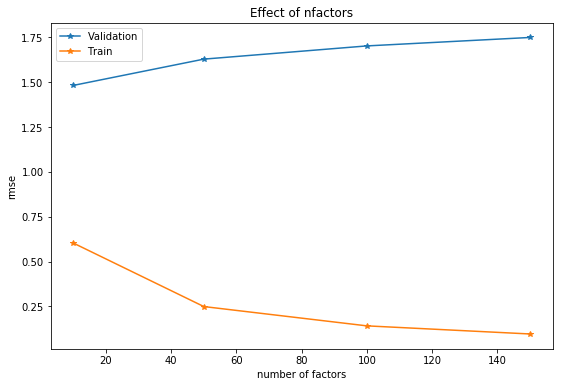

In [68]:
fig, axes = plt.subplots(1,1,figsize=(9,6))

axes.plot(factors_to_try, rmse_test,  '-*', label="Validation")
axes.plot(factors_to_try, rmse_train, '-*', label="Train")
axes.set_title('Effect of nfactors')
axes.set_xlabel('number of factors')
axes.set_ylabel('rmse')
axes.legend()
fig.savefig('svdpp_rmse_nfactors.eps')

# fig, axes = plt.subplots(1,1,figsize=(9,6))

# axes.plot(factors_to_try, rmse_train,  '-*', label="train")
# axes.set_title('Effect of nfactors')
# axes.set_xlabel('number of factors')
# axes.set_ylabel('rmse')
# axes.legend()
# fig.savefig('svd_rmse_nfactors_train.eps')

In [69]:
nfactors = 10
reg_lambdas = 10**np.linspace(-6,1,8)
rmse_train_lambda = np.zeros(len(reg_lambdas))
rmse_test_lambda  = np.zeros(len(reg_lambdas))
elapsed_time = np.zeros(len(reg_lambdas))
for i in range(len(reg_lambdas)):
    reg_lambda = reg_lambdas[i]
    
    t = time.time()
    algo = SVDpp(biased=False, n_epochs = 40, n_factors = nfactors, reg_all=reg_lambda,verbose=True)
    algo.fit(train1)
    elapsed_time[i] = time.time() - t
    
    testpredictions  = algo.test(test1, clip=False)
    trainpredictions = algo.test(trainest1, clip=False)
    
    rmse_train_lambda[i] = accuracy.rmse(trainpredictions)
    rmse_test_lambda[i]  = accuracy.rmse(testpredictions)
    
    print(reg_lambda,rmse_train_lambda[i],rmse_test_lambda[i], 'time = ', elapsed_time[i])

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 20
 processing epoch 21
 processing epoch 22
 processing epoch 23
 processing epoch 24
 processing epoch 25
 processing epoch 26
 processing epoch 27
 processing epoch 28
 processing epoch 29
 processing epoch 30
 processing epoch 31
 processing epoch 32
 processing epoch 33
 processing epoch 34
 processing epoch 35
 processing epoch 36
 processing epoch 37
 processing epoch 38
 processing epoch 39
RMSE: 0.5542
RMSE: 1.4802
1e-06 0.554166549638 1.48019698305 time =  326.726266146
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 proces

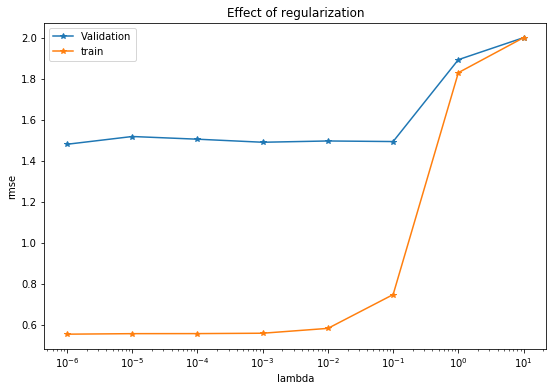

In [70]:
fig, axes = plt.subplots(1,1,figsize=(9,6))

# axes[0].plot(factors_to_try, rmse_train, '-*', label="train")
axes.semilogx(reg_lambdas, rmse_test_lambda, '-*', label="Validation")
axes.semilogx(reg_lambdas, rmse_train_lambda, '-*', label="train")
axes.set_title('Effect of regularization')
axes.set_xlabel('lambda')
axes.set_ylabel('rmse')
axes.legend()
fig.savefig('svdpp_rmse_lambda.eps')

# axes[1].semilogx(reg_lambdas, rmse_test_lambda, '-*', label="test")
# axes[1].set_title('Effect of regularization')
# axes[1].set_xlabel('lambda')
# axes[1].set_ylabel('rmse')
# axes[1].legend()

In [7]:
t = time.time()
algo = SVDpp(biased=False, n_epochs = 20, n_factors = 10, reg_all=1e-6)
algo.fit(train1)
elapsed = time.time() - t

In [8]:
valid1dict = create_test_dict(test1)
user_ids = list(valid1dict.keys())

In [9]:
def recommendation_for_userids(algo, k, trainset, testdic, userids):
    user_est_true = defaultdict(list)
    allq = algo.qi
    numitem = len(trainset.all_items())
    
    for u in userids:
        u_numid = trainset.to_inner_uid(u)
        pu = algo.pu[u_numid]
        
        Iu = len(trainset.ur[u_numid])  # nb of items rated by u
        u_impl_feedback = (sum(algo.yj[j] for (j, _) in trainset.ur[u_numid]) / np.sqrt(Iu))
        user_est_true[u] = np.dot(allq, pu +  u_impl_feedback)
        
        # exclude those in train set    
        #user_items = [j for (j, _) in trainset.ur[u_numid]]
        #mask = np.ones(numitem, dtype=bool)
        #mask[user_items] = False
        #user_est_true[u] = (user_est_true[u])[mask]
        
        # sort to get largest k value
        user_est_true[u] = (-user_est_true[u]).argsort()[:k]
        user_est_true[u] = [trainset.to_raw_iid(j) for j in user_est_true[u]]
    
    return user_est_true

In [35]:
t = time.time()
user_reclist_dict = recommendation_for_userids(algo,50,train1,valid1dict,user_ids)
elapsed = time.time()-t
print(elapsed)

1219.8913111686707


In [10]:
testdict = create_test_dict(testset)
user_ids_test = list(testdict.keys())

In [13]:
testdict[3019852]

[1820911, 2329350, 713984, 2358174, 2550443]

In [23]:
t = time.time()
user_reclist_dict_test = recommendation_for_userids(algo,50,train1,testdict,user_ids_test)
elapsed = time.time()-t
print(elapsed)

1458.114243030548


In [71]:
def precision_recall_at_k_nothreshold(user_reclist_dict, traindict, testdict, k):
    '''Return precision and recall at k metrics'''
    precisions = dict()
    recalls = dict()

    for uid in user_reclist_dict.keys():
        
        rec_in_train = [j for j in range(k) if user_reclist_dict[uid][j] in traindict[uid] ]
        num_in_train = len(rec_in_train)
        
        n_rel   = len(testdict[uid])
        n_rec_k = k - num_in_train
        n_rel_and_rec_k = len([j for j in range(k) if user_reclist_dict[uid][j] in testdict[uid]])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    # return precisions, recalls, numzero_n_rec_k
    return precisions, recalls

In [72]:
klist = list(range(1,51))
precision = np.zeros(len(klist))
recall = np.zeros(len(klist))
f1 = np.zeros(len(klist))

for t,k in enumerate(klist):
    precisions, recalls = precision_recall_at_k_nothreshold(user_reclist_dict, train1dic, valid1dict, k=k)
    precision[t] = sum(prec for prec in precisions.values()) / len(precisions)
    recall[t] = sum(rec for rec in recalls.values()) / len(recalls)
    f1[t] = 2*(precision[t]*recall[t])/(precision[t]+recall[t])
    print('k = ', k, precision[t], recall[t], f1[t])

k =  1 0.000174109863324 0.000152346130408 0.000162502539102
k =  2 0.000195873596239 0.000306143176344 0.000238897854373
k =  3 0.000130582397493 0.000306143176344 0.000183075653628
k =  4 0.000130582397493 0.000378688952729 0.000194199462938
k =  5 0.000139287890659 0.000427736205894 0.000210144416224
k =  6 0.000137836975131 0.000472714587252 0.000213438316505
k =  7 0.000143018816302 0.000535829412707 0.000225775615433
k =  8 0.000141464263951 0.000629102553774 0.000230987184166
k =  9 0.00014509155277 0.000713981112144 0.000241173145044
k =  10 0.000147993383825 0.000855445376094 0.000252332799853
k =  11 0.000138496482189 0.00087720910901 0.000239223603365
k =  12 0.000126955108674 0.00087720910901 0.000221808695834
k =  13 0.000120537597686 0.000920736574841 0.000213168400333
k =  14 0.000121255083386 0.000996909640045 0.000216212082172
k =  15 0.000127680566437 0.00110935559344 0.000229004058483
k =  16 0.000125141464264 0.00116739221455 0.000226050854216
k =  17 0.000125461519

In [73]:
klist = list(range(1,51))
precision_test = np.zeros(len(klist))
recall_test = np.zeros(len(klist))
f1_test = np.zeros(len(klist))

for t,k in enumerate(klist):
    precisions_test, recalls_test = precision_recall_at_k_nothreshold(user_reclist_dict_test, train1dic, testdict, k=k)
    precision_test[t] = sum(prec for prec in precisions_test.values()) / len(precisions_test)
    recall_test[t] = sum(rec for rec in recalls_test.values()) / len(recalls_test)
    f1_test[t] = 2*(precision_test[t]*recall_test[t])/(precision_test[t]+recall_test[t])
    print('k = ', k, precision_test[t], recall_test[t], f1_test[t])

k =  1 0.000130941469163 8.72943127755e-05 0.000104753175331
k =  2 0.000152765047357 0.000232784834068 0.000184471000582
k =  3 0.000160039573422 0.000282667298511 0.0002043697839
k =  4 0.000218235781939 0.000490406978557 0.000302054452257
k =  5 0.000192047488106 0.000523142345848 0.000280955261589
k =  6 0.000181863151616 0.000610436658623 0.000280237185884
k =  7 0.000199529857773 0.0008104861254 0.000320224994499
k =  8 0.000196412203745 0.000892688269931 0.00032198107446
k =  9 0.000193987361723 0.000986217890762 0.000324204296347
k =  10 0.000183318056829 0.00105168862534 0.000312214529637
k =  11 0.000178556548859 0.00109679068694 0.000307115041902
k =  12 0.000167314099486 0.00114043784333 0.000291815786358
k =  13 0.000164516204846 0.00122773215611 0.000290152016774
k =  14 0.00016211800944 0.00132593825798 0.000288911751163
k =  15 0.000157129762996 0.00135503636224 0.000281604697918
k =  16 0.000152765047357 0.00142050709682 0.000275863059954
k =  17 0.000148913827676 0.00

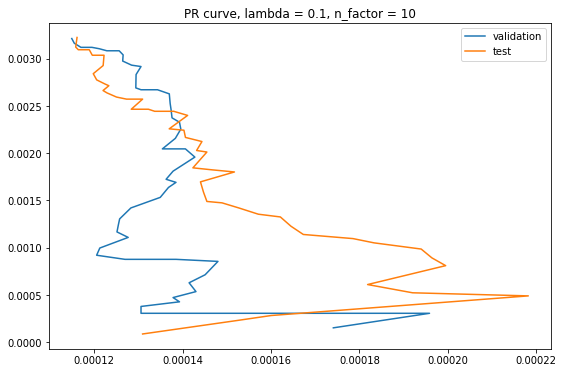

In [74]:
fig, axes = plt.subplots(1,1,figsize=(9,6))
# axes.step(recall,precision,'-o',where='post')
# axes.fill_between(recall,precision,step='post',alpha=0.2,color='b')

axes.plot(precision, recall,'-',label="validation")
axes.plot(precision_test, recall_test,'-', label="test")
axes.set_title('PR curve, lambda = 0.1, n_factor = 10')
axes.legend()
fig.savefig('svdpp_pr_k.eps')

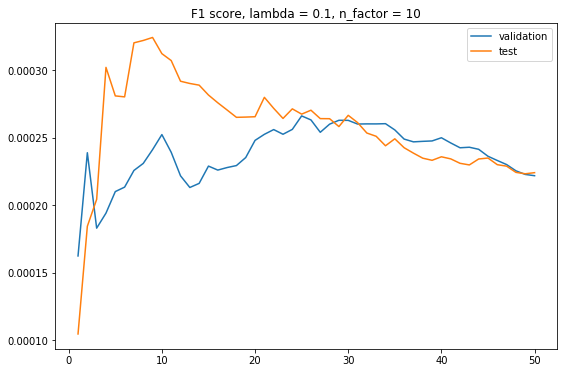

In [75]:
fig, axes = plt.subplots(1,1,figsize=(9,6))

axes.plot(klist, f1,'-', label="validation")
axes.plot(klist, f1_test,'-', label="test")
axes.set_title('F1 score, lambda = 0.1, n_factor = 10')
axes.legend()
fig.savefig('svdpp_f1_k.eps')

## Aggregate Diversity

In [63]:
k = 50
user_reclist_first_k = dict()

for u in user_reclist_dict_test.keys():
   user_reclist_first_k[u] = user_reclist_dict_test[u][:k]

In [64]:
print(user_reclist_dict_test[user_ids[0]])
print(user_reclist_first_k[user_ids[0]])

[2301493, 2036371, 2485289, 2589291, 1357033, 2338629, 1728491, 2150286, 668599, 1921893, 2439631, 1545833, 1549998, 2086434, 1371185, 831593, 2722466, 2648952, 2198938, 672435, 2542787, 2458704, 413471, 1592379, 1481739, 2133170, 1744088, 2375820, 1717525, 2211342, 2500321, 2323339, 2722840, 1587499, 2829406, 2230111, 2497387, 311402, 2818137, 2307280, 1567101, 1747269, 1731877, 1719050, 882311, 2379412, 1110122, 1705355, 2540376, 2339865]
[2301493, 2036371, 2485289, 2589291, 1357033, 2338629, 1728491, 2150286, 668599, 1921893, 2439631, 1545833, 1549998, 2086434, 1371185, 831593, 2722466, 2648952, 2198938, 672435, 2542787, 2458704, 413471, 1592379, 1481739, 2133170, 1744088, 2375820, 1717525, 2211342, 2500321, 2323339, 2722840, 1587499, 2829406, 2230111, 2497387, 311402, 2818137, 2307280, 1567101, 1747269, 1731877, 1719050, 882311, 2379412, 1110122, 1705355, 2540376, 2339865]


In [65]:
dict_for_aggregate = utils.invert_dict(user_reclist_first_k)
aggregate_diversity = len(dict_for_aggregate.keys())
print(aggregate_diversity)

79786


## Dicovery Ratio

In [66]:
klist = [1,9,15]
for t,k in enumerate(klist):
    user_reclist_first_k = dict()
    for u in user_reclist_dict_test.keys():
       user_reclist_first_k[u] = user_reclist_dict_test[u][:k]
    discov = dict()
    for u in user_reclist_first_k.keys():
        discov[u] = (k - len([j for j in range(k) if user_reclist_dict_test[u][j] in testdict[u]]))/k
    discov[t] = sum(dis for dis in discov.values()) / len(discov)
    print(discov[t])

0.9998690585308367
0.9998060126382771
0.9998428702370039


In [19]:
import math

In [20]:
def ndcg(recs, gt):
    '''
    input: 1. recs = recommendation list for one user.
                recs = 
           2. gt = ratings of a user in the test set.
                gt = a dictionary of lists with (key = each user) and (value = a list of items for this user)
           
    output: ndcg for a MODEL (not for each user) with a specific setting.
    '''
    Q, S = 0.0, 0.0
    for u, vs in gt.items():
        rec = recs.get(u, [])
        if not rec:
            continue

        idcg = sum([1.0 / math.log(i + 2, 2) for i in range(len(vs))])
        dcg = 0.0
        for i, r in enumerate(rec):
            if r not in vs:
                continue
            rank = i + 1
            dcg += 1.0 / math.log(rank + 1, 2)
        ndcg = dcg / idcg
        S += ndcg
        Q += 1
    return S / Q

In [25]:
k = 1
user_reclist_first_k = dict()
for u in user_reclist_dict_test.keys():
    user_reclist_first_k[u] = user_reclist_dict_test[u][:k]

In [28]:
ndcg(user_reclist_first_k,testdict)

0.00025382975063556777